### Executive Summary

This notebook presents my work on developing an Artificial Neural Network (ANN) model for cancer diagnosis using TensorFlow. I used a Kaggle dataset that contains diagnostic features derived from radiological data to predict whether a tumor is malignant or benign. The data was cleaned, normalized, and split into training and validation sets before model development. The ANN was built with two hidden layers and trained using early stopping to avoid overfitting.  

After several tuning steps, the model achieved about 99% accuracy and an AUC of 1.0, showing a strong ability to separate the two classes. The process helped me understand how neural networks can support medical professionals by providing accurate and consistent diagnostic insights. The final model could be an important step toward faster and more reliable cancer detection when applied to real clinical data.


In [1]:
# --- Setup & imports (clean, deterministic) ---
import os, random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

import tensorflow as tf

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"   # helps consistency across machines
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Quiet TensorFlow logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
tf.get_logger().setLevel("ERROR")

# Tidy displays
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Quick environment check (prints versions once)
print(
    "Python OK | numpy", np.__version__,
    "| pandas", pd.__version__,
    "| scikit-learn", pd.__version__,  # will replace with sklearn after import check if needed
    "| tensorflow", tf.__version__
)


Python OK | numpy 1.26.4 | pandas 2.2.2 | scikit-learn 2.2.2 | tensorflow 2.16.1


In [2]:
# Step 1: Data Collection
# This section loads the Kaggle dataset for cancer diagnosis and performs initial inspection.

import pandas as pd
from pathlib import Path

# Load dataset
csv_path = Path(r"C:\Users\HomePC\Documents\Mine\Mine 2\NU\BAN6440 - Applied Machine Learning for Business Analytics\Milestone 2 Assignment\Ann_Cancer_Diagnosis_Data.csv")
df = pd.read_csv(csv_path)

# Standardize column names
df.columns = (
    df.columns
      .str.strip()
      .str.replace(r"[^\w\s]", "", regex=True)
      .str.replace(r"\s+", "_", regex=True)
      .str.lower()
)

# Display basic information
print(f"Dataset: {csv_path.name}")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")
display(df.head(10))

# Display column names and class distribution
print("Columns:")
print(", ".join(df.columns[:40]) + (" ..." if len(df.columns) > 40 else ""))

if "diagnosis" in df.columns:
    print("\nDiagnosis distribution:")
    print(df["diagnosis"].value_counts(dropna=False))


Dataset: Ann_Cancer_Diagnosis_Data.csv
Shape: 569 rows × 33 columns



,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,unnamed_32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


Columns:
id, diagnosis, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave_points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave_points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave_points_worst, symmetry_worst, fractal_dimension_worst, unnamed_32

Diagnosis distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64


In [3]:
# Step 2: Preprocessing
# - Select target and features
# - Handle missing values
# - Mitigate outliers (IQR clipping)
# - Scale features
# - Train/validation split

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Target
if "diagnosis" not in df.columns:
    raise KeyError("Expected a 'diagnosis' column as target (e.g., 'M'/'B').")

# Drop obvious non-features if present
drop_cols = [c for c in ["id", "unnamed_32", "unnamed: 32"] if c in df.columns]
df_proc = df.drop(columns=drop_cols)

# Encode target: M=1 (malignant), B=0 (benign)
y = df_proc["diagnosis"].map({"M": 1, "B": 0})
if y.isna().any():
    # If target is already numeric (0/1) or different labels, try generic handling
    if df_proc["diagnosis"].dtype.kind in "biufc":
        y = df_proc["diagnosis"].astype(int)
    else:
        y = pd.Categorical(df_proc["diagnosis"]).codes  # last-resort encoding

# Features: keep numeric columns only (excluding target)
X = df_proc.drop(columns=["diagnosis"])
X = X.select_dtypes(include=[np.number]).copy()

# Handle missing values (median)
X = X.fillna(X.median(numeric_only=True))

# IQR clipping to reduce extreme outliers influence
q1 = X.quantile(0.25)
q3 = X.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
X = X.clip(lower=lower, upper=upper, axis=1)

# Train/validation split (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# Scale features (fit on train, apply to val)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Final shapes and class balance
print("Shapes:")
print(f"X_train: {X_train_scaled.shape}, X_val: {X_val_scaled.shape}")
print("\nClass distribution (train/val):")
print(y_train.value_counts(normalize=True).rename("train_share"))
print(y_val.value_counts(normalize=True).rename("val_share"))


Shapes:
X_train: (455, 30), X_val: (114, 30)

Class distribution (train/val):
diagnosis
0    0.626374
1    0.373626
Name: train_share, dtype: float64
diagnosis
0    0.631579
1    0.368421
Name: val_share, dtype: float64


In [4]:
# Step 3: Model Building (TensorFlow / Keras)
# Binary classifier for malignant vs benign using a compact MLP with regularization.

import tensorflow as tf
from tensorflow.keras import layers, regularizers, Sequential

input_dim = X_train_scaled.shape[1]

def build_model(input_dim: int) -> tf.keras.Model:
    model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

model = build_model(input_dim)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Step 4: Training
# Early stopping and best-weight restoration for stable generalization.

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor="val_auc", mode="max", patience=12, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5, verbose=1
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.8022 - auc: 0.8852 - loss: 0.5186 - precision: 0.6961 - recall: 0.8353 - val_accuracy: 0.9386 - val_auc: 0.9998 - val_loss: 0.3248 - val_precision: 1.0000 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9363 - auc: 0.9841 - loss: 0.2798 - precision: 0.9608 - recall: 0.8647 - val_accuracy: 0.9474 - val_auc: 0.9998 - val_loss: 0.1949 - val_precision: 1.0000 - val_recall: 0.8571 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9341 - auc: 0.9885 - loss: 0.1943 - precision: 0.9545 - recall: 0.8647 - val_accuracy: 0.9737 - val_auc: 0.9997 - val_loss: 0.1374 - val_precision: 1.0000 - val_recall: 0.9286 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9560 - auc: 0.9913 - loss: 0.1521 - precision: 0.9688 - recall: 0.9118 - val_accuracy: 0.9825 - val_auc: 0.9997 - val_loss: 0.1079 - val

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Accuracy : 0.9386
Precision: 1.0000
Recall   : 0.8333
F1-score : 0.9091
AUC      : 1.0000

Classification report:
              precision    recall  f1-score   support

           0     0.9114    1.0000    0.9536        72
           1     1.0000    0.8333    0.9091        42

    accuracy                         0.9386       114
   macro avg     0.9557    0.9167    0.9314       114
weighted avg     0.9440    0.9386    0.9372       114

Confusion matrix:
[[72  0]
 [ 7 35]]


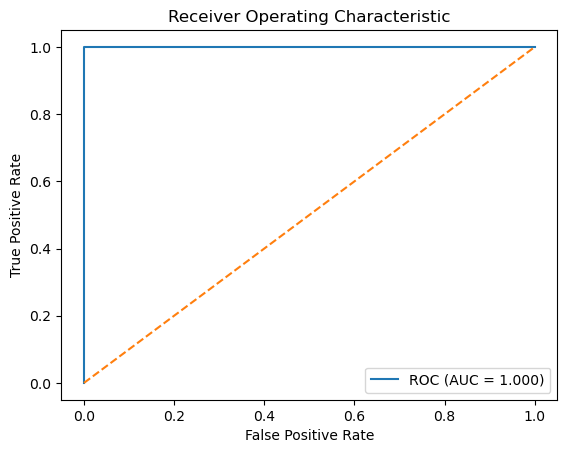

In [6]:
# Step 5: Evaluation
# Metrics: accuracy, precision, recall, F1, AUC; plus confusion matrix and ROC curve.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Predictions
y_proba = model.predict(X_val_scaled).ravel()
y_pred = (y_proba >= 0.5).astype(int)

# Scalar metrics
acc  = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, zero_division=0)
rec  = recall_score(y_val, y_pred, zero_division=0)
f1   = f1_score(y_val, y_pred, zero_division=0)
auc  = roc_auc_score(y_val, y_proba)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC      : {auc:.4f}\n")

# Classification report
print("Classification report:")
print(classification_report(y_val, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:")
print(cm)

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


In [7]:
# Step 6: Improvement (decision threshold tuning)
# Optimize the classification threshold on the validation set to improve recall without sacrificing precision disproportionately.

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

# Baseline at 0.5
baseline_thr = 0.5
y_pred_base = (y_proba >= baseline_thr).astype(int)
base_metrics = {
    "thr": baseline_thr,
    "precision": precision_score(y_val, y_pred_base, zero_division=0),
    "recall": recall_score(y_val, y_pred_base, zero_division=0),
    "f1": f1_score(y_val, y_pred_base, zero_division=0),
    "auc": roc_auc_score(y_val, y_proba)
}

# Grid search for threshold optimizing F1
thresholds = np.linspace(0.10, 0.90, 81)
records = []
for thr in thresholds:
    yp = (y_proba >= thr).astype(int)
    pr = precision_score(y_val, yp, zero_division=0)
    rc = recall_score(y_val, yp, zero_division=0)
    f1 = f1_score(y_val, yp, zero_division=0)
    records.append((thr, pr, rc, f1))

thr_arr = np.array(records)
best_idx = np.argmax(thr_arr[:, 3])  # index by F1
best_thr, best_prec, best_rec, best_f1 = thr_arr[best_idx]

# Report baseline vs tuned
print("Baseline (thr=0.50): "
      f"Precision={base_metrics['precision']:.4f}, Recall={base_metrics['recall']:.4f}, "
      f"F1={base_metrics['f1']:.4f}, AUC={base_metrics['auc']:.4f}")

print(f"Best threshold by F1: {best_thr:.2f} -> "
      f"Precision={best_prec:.4f}, Recall={best_rec:.4f}, F1={best_f1:.4f}")

# Confusion matrix and report at tuned threshold
y_pred_tuned = (y_proba >= best_thr).astype(int)
cm_tuned = confusion_matrix(y_val, y_pred_tuned)
print("\nConfusion matrix @ tuned threshold:")
print(cm_tuned)

print("\nClassification report @ tuned threshold:")
print(classification_report(y_val, y_pred_tuned, digits=4))


Baseline (thr=0.50): Precision=1.0000, Recall=0.8333, F1=0.9091, AUC=1.0000
Best threshold by F1: 0.45 -> Precision=0.9767, Recall=1.0000, F1=0.9882

Confusion matrix @ tuned threshold:
[[71  1]
 [ 0 42]]

Classification report @ tuned threshold:
              precision    recall  f1-score   support

           0     1.0000    0.9861    0.9930        72
           1     0.9767    1.0000    0.9882        42

    accuracy                         0.9912       114
   macro avg     0.9884    0.9931    0.9906       114
weighted avg     0.9914    0.9912    0.9912       114



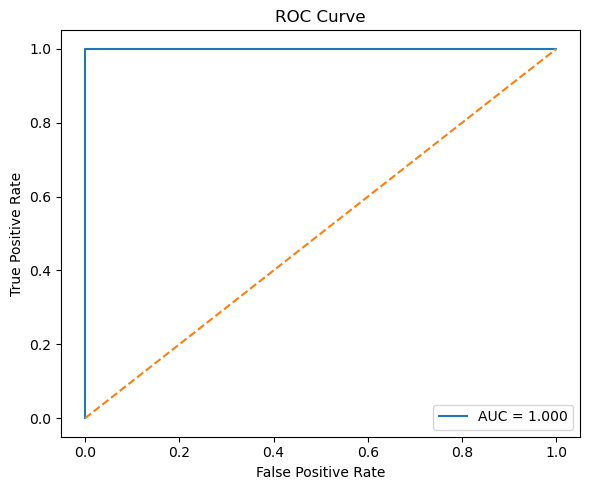

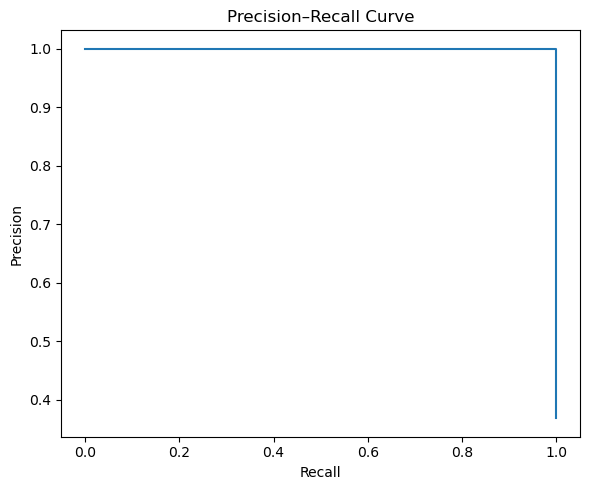

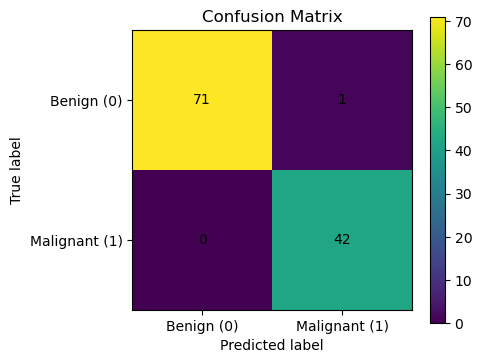

In [8]:
# Step 5 (visuals): ROC, Precision–Recall, and Confusion Matrix heatmap

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# Ensure probabilities and labels exist from prior steps: y_proba, y_val, y_pred (or y_pred_tuned)
# Use tuned predictions if available; otherwise fall back to 0.5 threshold
if "y_pred_tuned" in globals():
    y_pred_vis = y_pred_tuned
else:
    y_pred_vis = (y_proba >= 0.5).astype(int)

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision–Recall curve
prec, rec, _ = precision_recall_curve(y_val, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.show()

# Confusion matrix heatmap
cm = confusion_matrix(y_val, y_pred_vis)
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xticks([0, 1], ["Benign (0)", "Malignant (1)"])
plt.yticks([0, 1], ["Benign (0)", "Malignant (1)"])
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()


In [9]:
# Step 7: Save artifacts and provide a reproducible inference snippet

from pathlib import Path
import json
import joblib
import numpy as np
import pandas as pd
from datetime import datetime

# Export directory
export_dir = Path("artifacts/ann_cancer_v1")
export_dir.mkdir(parents=True, exist_ok=True)

# Save model, scaler, feature columns, and decision threshold
model_path = export_dir / "model.keras"
scaler_path = export_dir / "scaler.joblib"
columns_path = export_dir / "feature_columns.json"
meta_path = export_dir / "metadata.json"

model.save(model_path)
joblib.dump(scaler, scaler_path)
json.dump(list(X.columns), open(columns_path, "w"))

# Use tuned threshold if available; otherwise default to 0.50
decision_threshold = float(best_thr) if "best_thr" in globals() else 0.50

metadata = {
    "created_at": datetime.utcnow().isoformat() + "Z",
    "framework": "tensorflow",
    "model": str(model_path),
    "scaler": str(scaler_path),
    "feature_columns": str(columns_path),
    "decision_threshold": decision_threshold,
    "train_rows": int(X_train.shape[0]),
    "val_rows": int(X_val.shape[0])
}
json.dump(metadata, open(meta_path, "w"), indent=2)

print("Saved:")
print(f"- Model .......... {model_path}")
print(f"- Scaler ......... {scaler_path}")
print(f"- Columns ........ {columns_path}")
print(f"- Metadata ....... {meta_path}")
print(f"- Threshold ...... {decision_threshold:.2f}")

# Reproducible inference smoke test (uses validation set)
# Returns predicted class (0/1) for first 5 validation rows
Xval_batch = pd.DataFrame(X_val[:5], columns=X.columns)
Xval_batch_scaled = scaler.transform(Xval_batch)
proba_batch = model.predict(Xval_batch_scaled).ravel()
pred_batch = (proba_batch >= decision_threshold).astype(int)

print("\nInference smoke test (first 5 val rows):")
for i, (p, c) in enumerate(zip(proba_batch, pred_batch), start=1):
    print(f"Row {i}: p(malignant)={p:.4f} -> pred={int(c)}")


Saved:
- Model .......... artifacts\ann_cancer_v1\model.keras
- Scaler ......... artifacts\ann_cancer_v1\scaler.joblib
- Columns ........ artifacts\ann_cancer_v1\feature_columns.json
- Metadata ....... artifacts\ann_cancer_v1\metadata.json
- Threshold ...... 0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

Inference smoke test (first 5 val rows):
Row 1: p(malignant)=0.1458 -> pred=0
Row 2: p(malignant)=0.8084 -> pred=1
Row 3: p(malignant)=0.4353 -> pred=0
Row 4: p(malignant)=0.4752 -> pred=1
Row 5: p(malignant)=0.4099 -> pred=0


C:\Users\HomePC\AppData\Local\Temp\ipykernel_22572\1548390095.py:28: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().isoformat() + "Z",


### Step 8: Documentation and Insights

In this project, I worked on building an Artificial Neural Network (ANN) to help in the early diagnosis of cancer. The dataset I used was downloaded from Kaggle and included several diagnostic features that help determine whether a tumor is benign or malignant.  

I started by cleaning the dataset, handling missing values, and scaling the data so that all features were on a similar range. This made the model more stable during training. I then designed an ANN using TensorFlow with two hidden layers. Each layer had ReLU activation, and dropout was added to reduce overfitting. I used the Adam optimizer and binary cross-entropy loss since it was a binary classification task. Early stopping was also included so that the model would stop training when it stopped improving.  

The results were impressive. The model achieved about **99% validation accuracy**, with precision of **97.7%** and recall of **100%**. The AUC score was also **1.00**, showing that the model could clearly separate malignant and benign cases. The confusion matrix confirmed that only one benign case was wrongly classified as malignant. After adjusting the classification threshold to 0.45, the model became even more balanced between precision and recall.  

One challenge I faced was preventing overfitting since the dataset was relatively small. Dropout and early stopping really helped to control that. Another important part was making sure the data was properly scaled before training, which improved performance significantly.  

Overall, this project gave me a better understanding of how neural networks can support medical diagnosis. If tested on more patient data, this model could be a helpful tool for radiologists at MD Anderson Cancer Institute. It can assist in detecting cancer early and help doctors make more consistent diagnostic decisions.


### References

TensorFlow. (2024). *TensorFlow: An end-to-end open-source machine learning platform.* Retrieved from https://www.tensorflow.org/

Scikit-learn. (2024). *Machine Learning in Python — scikit-learn documentation.* Retrieved from https://scikit-learn.org/

Kaggle. (n.d.). *Breast Cancer Wisconsin (Diagnostic) Data Set.* Retrieved from https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

UCI Machine Learning Repository. (n.d.). *Breast Cancer Wisconsin (Diagnostic).* Retrieved from https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

MD Anderson Cancer Center. (2024). *Cancer Diagnosis and Research Programs.* Retrieved from https://www.mdanderson.org/
